In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.cross_validation import train_test_split
import datetime as dt
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns  
sns.set_style("darkgrid")
%matplotlib inline

C:\Users\shenx\Anaconda3\envs\py363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## First let us create a data preprocess class
In this class, we will perform:
- loading data from the given path
- get the features:
    - Our goal is first to perform the multivariate regression for the "Total Power"; Thus, this module would return trainFeatures, testFeatures, trainY, and testY
    - But still, we also need to perform regression on time series; since the given time series is in String format which is NOT trainable, we perform the "Ordinal" transformation to convert the time string into ordinal time format for training purpose
    - Thus in total, using this class, one would be able to get **trainFeature**, **testFeature**, **trainY**, **testY**, **trainOrdinalTime**, and **testOrdinalTime** with given Train/ Test split ratio
    - Also, we performed PCA onto the features if users want to
    


In [2]:
class dataPreprocess(object):
    def __init__(self, topPCAComponents = 0.95, datapath = "./data/processed_data.pkl", testSize = 0.33):
        self.topPCAComponent = topPCAComponents
        self.pcaOrNot = None
        self.datapath = datapath
        self.df = None
        self.testSize = testSize                        #where to split the dataset into train and test set
        
    def loadData(self):
        self.df = pd.read_pickle(self.datapath)
        self.labels = self.df['Total_power']
        self.df = self.df.drop('Total_power', 1)
    
    def getFeatures(self, pcaOrNot = False):
        self.pcaOrNot = pcaOrNot                        #this feature generator would create a version with PCA

        dates = self.df.index.values                    #extract the dats from the index
        self.df['Date'] = pd.to_datetime(dates)         #create a new feature of dates
        
        #as the date is in the string form we need to convert it into the ordinal form
        self.df['Date']=self.df['Date'].map(dt.datetime.toordinal)
        features = self.df.values
        
        X_train, X_test, y_train, y_test = train_test_split(features, self.labels, test_size=self.testSize, random_state=42)
        features = np.delete(features, -1, axis = 1) #remove the time info from the features
        
        #also, we need to seperate the date out from the features as it is not going to be used in the regression
        X_train_ordinal = X_train[:,-1]
        X_test_ordinal = X_test[:,-1]
        
        trainFeatures =  np.delete(X_train, -1, axis=1)  #we do not need the ordinal time as our train features
        testFeatures = np.delete(X_test, -1, axis= 1)    #same for the test features
        
        #if user wants to use PCA for feature deduction and to prevent overfitting
        if self.pcaOrNot:
            #get data normalized 
            scaler = StandardScaler()
            #normalize the data over the whole dataset
            scaler.fit(features)
            trainFeatures = scaler.transform(trainFeatures)
            testFeatures = scaler.transform(testFeatures)

            #get the PCA
            pca = PCA(self.topPCAComponent)
            pca.fit(trainFeatures)
            trainFeatures, testFeatures = pca.transform(trainFeatures), pca.transform(testFeatures)
            
        return trainFeatures, testFeatures, y_train, y_test, X_train_ordinal, X_test_ordinal
            
    '''If we want to perform the regression on date against variables, 
       we need to convert the date into ordinal form to be a trainable'''
    def fromOrdinal(self,ordinalTime):
        xx = datetime.fromordinal(ordinalTime)
        return {'year': xx.year, 'month':xx.month, 'day' : xx.day}

    def toOrdinal(self, stringDate):
        '''input args: @string, yyyy-mm-dd'''
        d = datetime.strptime(stringDate, '%Y-%m-%d').date()
        return {stringDate : dt.toOrdinal()}
        

## Now since we have create our class for getting our data let us get our needed dataframe to see how it looks like

In [3]:
processer = dataPreprocess()
processer.loadData()
print("There are in total {} data points and {} features".format(len(processer.df), len(processer.df.columns)))
processer.df.head()

There are in total 49422 data points and 13 features


,AHU-1_supplyair_temp,AHU-1_outdoorair_enthalpy,AHU-1_outdoorair_dewpoint,AHU-1_outdoorair_temp,AHU-1_outdoorair_humidity,AHU-1_supplyair_flow_kCFM,AHU-1_mixedair_temp,wind_direction,solar_radiation,wind_speed,interiorLighting_realPower,1st_floor_temp,2nd_floor_temp
Date,,,,,,,,,,,,,
2017-10-01T00:10:00Z,75.66744,25.400291,48.079998,70.989320,43.200005,0.0,74.033720,287.769226,489.853900,3.168483,1.356390,71.623946,74.287681
2017-10-01T00:20:00Z,75.35050,25.333643,48.324005,70.407005,44.340004,0.0,73.750084,287.792328,489.858582,3.168723,1.356293,71.623889,74.287916
2017-10-01T00:30:00Z,75.05009,25.325240,48.728000,69.889170,45.680004,0.0,73.450000,287.815430,489.863251,3.168963,1.356196,71.623830,74.288152
2017-10-01T00:40:00Z,74.75041,25.272150,48.956000,69.471340,46.760002,0.0,73.150000,287.838562,489.867920,3.169204,1.356099,71.623774,74.288390
2017-10-01T00:50:00Z,74.45050,25.218866,49.070000,69.071884,47.700005,0.0,72.850420,287.861664,489.872600,3.169444,1.356002,71.623716,74.288623


From the given dataframe, we can see that we have multivariate features with timeseries as the index, the **target** is the "Total_power"

### As we are going to perform Multivariate regression with 13 features with 49422 datapoints, let us first split the label and the features; 

Let us first get the features processed without applying PCA

In [4]:
trainFeatures, testFeatures, y_train, y_test, X_train_ordinal, X_test_ordinal = processer.getFeatures()

### Let us operate the PCA onto the train and test data
The reason why we want to do it is because, we are not sure if all the features would be useful to the training process. Thus, we only want to project our data onto a lower dimensional axis where all the projections have a good variance for learning purpose; This is because as we are performing a multivariate regression, the dimension of our model is quite complex, but due to the learning theory which indicates that the training sample is approximately linear to the numbers of features, PCA then can be used to alleviate from overfitting

In [5]:
trainFeatures_pca, testFeatures_pca, _, _,_ ,_ = processer.getFeatures(pcaOrNot=True)

### Let us operate the Ridge Regression
By definition, the ridge regression is adding a Norm2 constrains onto the learning parameters. Before adding regularization, the model might try too hard to fit the noise, which would cause a high variance, thus, by introducing the regularization, we acutally allow some of the noise to introduce a little bit bias, but according to the learning theory, this would in turn trade off the overall low variance

But, how do we find the best $\lambda$ ? Let us use the grid search

In [6]:
def findRidge(alphaStart, alphdaEnd, interval):    
    alphas = np.linspace(alphaStart,alphdaEnd,interval)
    ridgeRegression = Ridge()
    clf = GridSearchCV(estimator=ridgeRegression, param_grid=dict(alpha=alphas), n_jobs=-1)
    clf.fit(trainFeatures, y_train)

    clf2 = GridSearchCV(estimator=ridgeRegression, param_grid=dict(alpha=alphas), n_jobs=-1)
    clf2.fit(trainFeatures_pca, y_train)

    #get the best lambda for the ridge regression on the features w/o PCA
    bestLambda1 = clf.best_estimator_.alpha
    #get the best lambda for the ridge regression on the features with PCA
    bestLambda2 = clf2.best_estimator_.alpha
    
    ridgeNonePCA = Ridge(bestLambda1)
    ridgePCA = Ridge(bestLambda2)
    
    ridgeNonePCA.fit(trainFeatures,y_train)
    ridgePCA.fit(trainFeatures_pca,y_train)

    predNonePCA = ridgeNonePCA.predict(testFeatures)
    predPCA = ridgePCA.predict(testFeatures_pca)
    
    return ridgePCA,ridgeNonePCA,predNonePCA,predPCA

### Still, the boosting algorithm is still powerful, let us run the lightGBM for this regression as well

In [7]:
def getLGBModel(trainData, labels, testData, maxIter):
    params = {"objective" : "regression", "metric" : "rmse", "num_leaves" : 75, "learning_rate" : 0.01,
    "bagging_fraction" : 0.5, "feature_fraction" : 0.7, "bagging_frequency" : 5, "bagging_seed" : 2018,
    "verbosity" : -1}
    
    from sklearn.model_selection import train_test_split
    #we need to perform the validation as well
    trainData = pd.DataFrame(trainData, columns=['AHU-1_supplyair_temp', 'AHU-1_outdoorair_enthalpy',
       'AHU-1_outdoorair_dewpoint', 'AHU-1_outdoorair_temp',
       'AHU-1_outdoorair_humidity', 'AHU-1_supplyair_flow_kCFM',
       'AHU-1_mixedair_temp', 'wind_direction', 'solar_radiation',
       'wind_speed', 'interiorLighting_realPower', '1st_floor_temp',
       '2nd_floor_temp'])
    
    trainX, valX, trainy, valy = train_test_split(trainData, labels, test_size=0.3, random_state= 1)
    
    trainDataSet = lgb.Dataset(trainX, label=trainy)
    valDataSet = lgb.Dataset(valX, label=valy)
    evaluation = {}
    model = lgb.train(params, trainDataSet, maxIter, valid_sets=[valDataSet], 
                      early_stopping_rounds=100, verbose_eval=20, evals_result=evaluation)
    
    predY = model.predict(testData, num_iteration=model.best_iteration)
    
    return predY, model, evaluation

In [9]:
ridgePCA,ridgeNonePCA,predNonePCA,predPCA = findRidge(0,25,100)
predLGB, model, evaluation = getLGBModel(trainFeatures, y_train, testFeatures, 50000)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 8.46561
[40]	valid_0's rmse: 7.33847
[60]	valid_0's rmse: 6.43811
[80]	valid_0's rmse: 5.71843
[100]	valid_0's rmse: 5.15637
[120]	valid_0's rmse: 4.70992
[140]	valid_0's rmse: 4.35531
[160]	valid_0's rmse: 4.07871
[180]	valid_0's rmse: 3.87496
[200]	valid_0's rmse: 3.70908
[220]	valid_0's rmse: 3.58476
[240]	valid_0's rmse: 3.48509
[260]	valid_0's rmse: 3.40475
[280]	valid_0's rmse: 3.33997
[300]	valid_0's rmse: 3.28543
[320]	valid_0's rmse: 3.24277
[340]	valid_0's rmse: 3.20807
[360]	valid_0's rmse: 3.17805
[380]	valid_0's rmse: 3.15449
[400]	valid_0's rmse: 3.13296
[420]	valid_0's rmse: 3.11365
[440]	valid_0's rmse: 3.09883
[460]	valid_0's rmse: 3.08277
[480]	valid_0's rmse: 3.06664
[500]	valid_0's rmse: 3.05335
[520]	valid_0's rmse: 3.04088
[540]	valid_0's rmse: 3.02795
[560]	valid_0's rmse: 3.01732
[580]	valid_0's rmse: 3.0053
[600]	valid_0's rmse: 2.99671
[620]	valid_0's rmse: 2.98767
[640]	valid_

[5360]	valid_0's rmse: 2.66125
[5380]	valid_0's rmse: 2.66114
[5400]	valid_0's rmse: 2.66083
[5420]	valid_0's rmse: 2.66067
[5440]	valid_0's rmse: 2.66049
[5460]	valid_0's rmse: 2.66017
[5480]	valid_0's rmse: 2.65989
[5500]	valid_0's rmse: 2.65965
[5520]	valid_0's rmse: 2.65954
[5540]	valid_0's rmse: 2.65923
[5560]	valid_0's rmse: 2.65892
[5580]	valid_0's rmse: 2.65861
[5600]	valid_0's rmse: 2.65828
[5620]	valid_0's rmse: 2.65799
[5640]	valid_0's rmse: 2.65773
[5660]	valid_0's rmse: 2.65749
[5680]	valid_0's rmse: 2.65724
[5700]	valid_0's rmse: 2.65707
[5720]	valid_0's rmse: 2.6569
[5740]	valid_0's rmse: 2.65675
[5760]	valid_0's rmse: 2.65639
[5780]	valid_0's rmse: 2.65626
[5800]	valid_0's rmse: 2.65602
[5820]	valid_0's rmse: 2.65583
[5840]	valid_0's rmse: 2.65558
[5860]	valid_0's rmse: 2.65553
[5880]	valid_0's rmse: 2.65535
[5900]	valid_0's rmse: 2.65537
[5920]	valid_0's rmse: 2.65541
[5940]	valid_0's rmse: 2.65522
[5960]	valid_0's rmse: 2.65484
[5980]	valid_0's rmse: 2.65476
[6000]	va

In [47]:
def makePlots(options, plots, which):
    plt.figure(figsize= (8,6))

    if options == 'distribution':
        error = []
        for data in plots:
            #find the rmse between the ground truth and the prediction
            rmse = np.sqrt(mean_squared_error(plots[0], data))
            error.append(rmse)
            sns.distplot(data[0:len(data):100])
        plt.legend(['Ground Truth, RMSE {}'.format(round(error[0],3)),
                    'Ridge_No_PCA, RMSE {}'.format(round(error[1],3)), 
                    'RidgePCA RMSE {}'.format(round(error[2],3)), 
                    'LightGBM RMSE {}'.format(round(error[3],3))])
        
    elif options == 'kde':
        for data, w in zip(plots[1::], which):
            df = np.column_stack((plots[0], data))
            df = pd.DataFrame(df,columns=["GroundTruth", w])
            sns.jointplot(x= "GroundTruth", y= w , data= df, kind="kde")
            plt.title('Bivariate Plot with Ground Truth against {} prediction'.format(w), loc = 'center')
            
            
    plt.show()

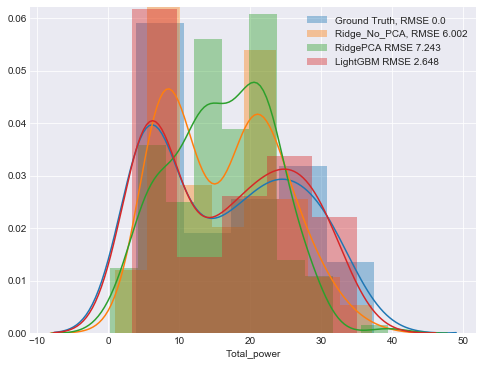

In [48]:
plots = [y_test, predNonePCA, predPCA, predLGB]
which = ['Ridge_No_PCA', 'RidgePCA', 'LightGBM']
makePlots('distribution', plots, which)

#### From the plot above, we can definitely see that lightGBM performs the best in terms of this multivariate regression with the lowest RMSE

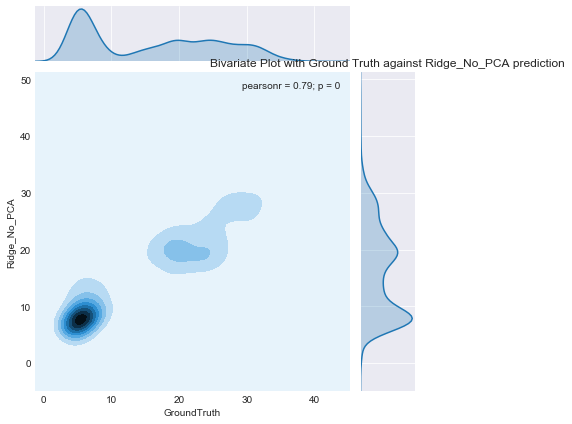

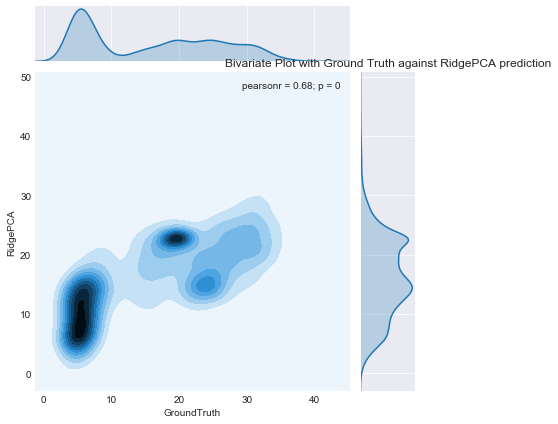

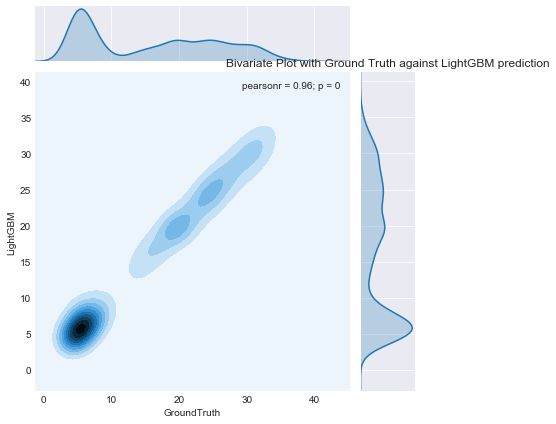

In [49]:
makePlots('kde', plots, which)

#### Still, from this KDE plot, we could also well visualize that the lightGBM shows the most correlated predicted distribution to the ground truth with a high pearson's rate of 0.96

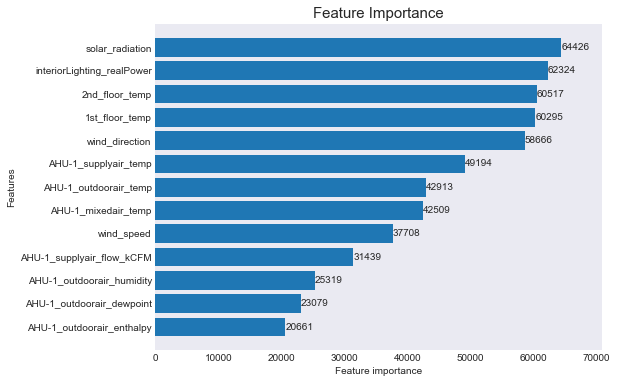

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
lgb.plot_importance(model, max_num_features=14, height=0.8, ax=ax)

ax.grid(False)
plt.title("Feature Importance", fontsize=15)
plt.show()

From the feature importance plot, we could clearly visualize that the most the important feature is **solar_radiation** which is counter intuitive to what we all expected that the **outdoor temperature** might be the key role determining the power consumption. Thus, in order to save more energy consumptions, we might suggest enhancing the anti- radiation protection to reducing the feeling of burning to humans.


## Let us now perform the regression on the timeseries to predict the power consumption on the given date
To perform this, we assumed that each feature follows the normal distribution according to the time, and similar to the naive assumtion of Naive Bayes where each features are not correlated to each other. 

Thus, we would perform multi- regressions on the timespan, and to predict the power consumption on a given date, we would first perform regression on that given timespan to gain all the needed features for our model to predict.

In [52]:
timeSpan = []
for ordTime in X_test_ordinal:
    converted = processer.fromOrdinal(int(ordTime))
    yr, month, day = str(converted['year']), str(converted['month']), str(converted['day'])
    date = month + '/'+ day + '/' + yr
    timeSpan.append(date)
timeSpan = np.array(timeSpan)

from sklearn.svm import SVR
clf = SVR(C=1.0, epsilon=0.2)
#the svr need the feature dimension to be 2D,   msample, n features
#but our only feature is the timeseries
X_train_ordinal2 = np.expand_dims(X_train_ordinal,1)
X_test_ordinal2 = np.expand_dims(X_test_ordinal,1)

#对于feature1来做一次regression
clf.fit(X_train_ordinal2, trainFeatures[:,0])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
#做一次对test 时间线的预测
pred= clf.predict(X_test_ordinal2)

In [57]:
#把时间和预测值cat一起显示一下
predDf = np.column_stack((pred, timeSpan))
predDf = pd.DataFrame(predDf, columns=['Predictions','timeSpan'])
predDf.head()

,Predictions,timeSpan
0,77.43300226248445,8/20/2018
1,71.65415649531728,3/27/2018
2,74.09997503109784,10/11/2017
3,88.10092229692913,1/1/2018
4,74.1484351484684,2/12/2018


In [66]:
#把时间和true值cat一起显示一下
testDf = np.column_stack((testFeatures[:,0], timeSpan))
testDf = pd.DataFrame(testDf, columns=['true Feature', 'timeSpan'])
testDf.head()

,true Feature,timeSpan
0,77.62154,8/20/2018
1,65.11414,3/27/2018
2,27.498539,10/11/2017
3,90.1,1/1/2018
4,72.6,2/12/2018


The prediction and the truth has a RMSE  9.92217783581


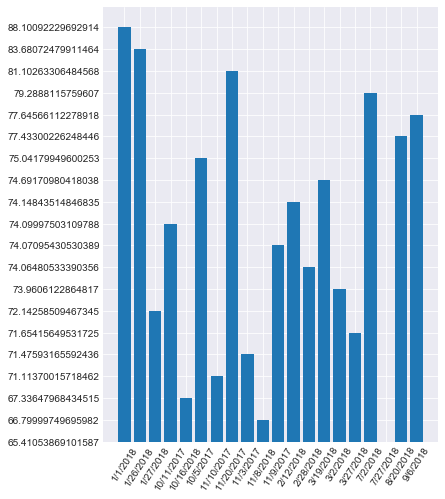

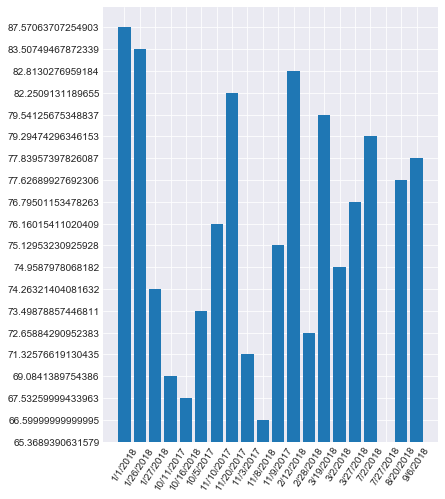

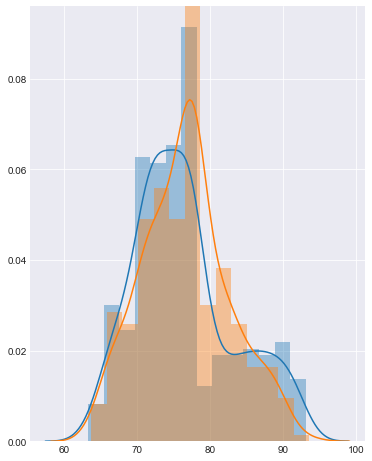

In [97]:
#对每一个时间点取一个均值
uniqueData = set(timeSpan)
#Since after the ordinal, many time such as 2019/10/1 20:00pm and 2019/10/1 21:00pm all become identical to 2019/10/1
#we need to get the values to the "same date" average out
def getAvg(uniqueData, pairs):
    import collections
    counts = collections.defaultdict(int)
    valueSum = collections.defaultdict(int)
    
    for pair in pairs:
        whichDate = pair[1]
        featureVal = float(pair[0])
        counts[whichDate] += 1
        valueSum[whichDate] += featureVal
        
    avgFeatureValue = []
    for date in counts.keys():
        thisFeatureAvg = valueSum[date] / counts[date]
        avgFeatureValue.append([thisFeatureAvg, date])
    return np.array(avgFeatureValue)


avgFeatureValuePred = getAvg(uniqueData, predDf.values)
avgFeatureValueTrue = getAvg(uniqueData, testDf.values)

plt.figure(figsize= (6,8))
plt.bar(avgFeatureValuePred[:,1][:20],
        avgFeatureValuePred[:,0][:20])
plt.xticks(rotation= 56)


plt.figure(figsize= (6,8))
plt.bar(avgFeatureValueTrue[:,1][:20],
        avgFeatureValueTrue[:,0][:20])
plt.xticks(rotation= 56)


rmse = mean_squared_error(avgFeatureValuePred[:,0].astype(np.float64), avgFeatureValueTrue[:,0].astype(np.float64))
print("The prediction and the truth has a RMSE ", rmse)
# fig, ax = plt.subplots(figsize = (10,10))
# barwidth = 0.35
# dates = avgFeatureValuePred[:,1][:20]
# x = np.arange(len(dates))
# rects1 = ax.bar(x - barwidth/2, avgFeatureValuePred[:,0][:20] , barwidth, label='Pred')
# rects2 = ax.bar(x + barwidth/2, avgFeatureValueTrue[:,0][:20], barwidth, label='True')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Feature values')
# ax.set_title('comparison')
# ax.set_xticks(x)
# ax.set_xticklabels(dates)
# ax.legend()
plt.figure(figsize= (6,8))
sns.distplot(avgFeatureValuePred[:,0].astype(np.float64))
sns.distplot(avgFeatureValueTrue[:,0].astype(np.float64))

From the top two graph, we can see that the predictions is quite closed to the ground truth given a certain date "month/day/year" and the last graph verifies our assumption that the feature values are distributed Normally. From the last we can clearly visualize this. Thus, this approach would work. And we can perform the similar regression to the other features with the date. 